#Installation

In [20]:
#install aimodelshare library
! pip install aimodelshare --upgrade
!pip install transformers
!pip install -q tf-models-official
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

In [21]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [23]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
import os
import shutil


In [24]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


#  Read Data

In [25]:
## Google Colab- Google Drive connectionsinstructions 

# This step needs to be done for the first time when you're reading something from the Shared Project Folder 
# Please navigate to "Shared with me" on your Gdrive home sceen
# Right click on the "NLP-Group1-FinalProj" (the primary folder for this project) and select "Add shortcut to Drive"
# This way the below code can find a link to the Project drive folder through your own drive.


# Mounting your personal Gdrive to the Colab notebook
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [26]:
# Reading the dataframe to Data folder as a csv
imdb_data = pd.read_csv('/content/drive/My Drive/NLP-Group1-FinalProj/Data/imdb.csv', sep=',')

In [27]:
#pos_neg_encoding = {'positive': 1, 'negative': 0}

# The values 10 and 20 are replaced by 'A' and 'B'
#imdb_data['sentiment'].replace(pos_neg_encoding, inplace=True)

# Creating two variables X and y for respective columns and attributes
y_train_labels = imdb_data['sentiment'].squeeze()
y = [1 if label =='positive' else 0 for label in y_train_labels]
X = imdb_data.loc[:, imdb_data.columns != 'sentiment'].squeeze()

In [28]:
from sklearn.model_selection import train_test_split

# Splitting the data into train-test datasets - Default .75/.25 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

# Preprocess data

In [10]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'@([a-zA-Z0-9_]{1,50})', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    return text

In [12]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [13]:
# Concatenate train data and test data
all_reviews = np.concatenate([X_train.values, X_val.values])
# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_reviews]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1235 > 512). Running this sequence through the model will result in indexing errors


Max length:  3157


In [14]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert(X_train[[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Model Train


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [16]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
#class BertClassifier(nn.Module):
"""Bert Model for Classification Tasks.
"""
#def __init__(self, freeze_bert=False):
"""
@param    bert: a BertModel object
@param    classifier: a torch.nn.Module classifier
@param    freeze_bert (bool): Set `False` to fine-tune the BERT model
"""
#super
#super(BertClassifier, self).__init__()
# Specify hidden size of BERT, hidden size of our classifier, and number of labels
freeze_bert=False
D_in, H, D_out = 768, 50, 2

# Instantiate BERT model
bert = BertModel.from_pretrained('bert-base-uncased')

# Instantiate an one-layer feed-forward classifier
classifier = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    #nn.Dropout(0.5),
    nn.Linear(H, D_out))


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 8.61 s, sys: 1.76 s, total: 10.4 s
Wall time: 12.8 s


In [17]:
bert.parameters()

<generator object Module.parameters at 0x7f9b84a57ad0>

In [18]:

# Freeze the BERT model
if freeze_bert:
    for param in bert.parameters():
        param.requires_grad = False
        
def forward(self, input_ids, attention_mask):
    """
    Feed input to BERT and the classifier to compute logits.
    @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                  max_length)
    @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                  information with shape (batch_size, max_length)
    @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                  num_labels)
    """
    # Feed input to BERT
    outputs = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask)
    
    # Extract the last hidden state of the token `[CLS]` for classification task
    last_hidden_state_cls = outputs[0][:, 0, :]

    # Feed input to classifier to compute logits
    logits = self.classifier(last_hidden_state_cls)

    return logits

In [19]:
# Instantiate Bert Classifier
bert_classifier = classifier(freeze_bert=False)

# Tell PyTorch to run the model on GPU
bert_classifier.to(device)

# Create the optimizer
optimizer = AdamW(bert_classifier.parameters(),
                  lr=5e-5,    # Default learning rate
                  eps=1e-8    # Default epsilon value
                  )

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, # Default value
                                            num_training_steps=total_steps)

TypeError: ignored

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

# Predict and Evaluate

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


AUC: nan
Accuracy: 100.00%


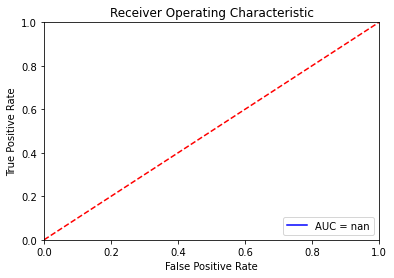

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# # Concatenate the train set and the validation set
# full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
# full_train_sampler = RandomSampler(full_train_data)
# full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# # Train the Bert Classifier on the entire training data
# set_seed(42)
# bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
# train(bert_classifier, full_train_dataloader, epochs=3)

In [ ]:
# # Compute predicted probabilities on the test set
# probs = bert_predict(bert_classifier, val_dataloader)

# # Evaluate the Bert classifier
# evaluate_roc(probs, y_val)

# Model saving ONXX

In [ ]:
bert_classifier.summary()

AttributeError: ignored

In [ ]:

export_dir='./imdb_trained_bert'
tf.saved_model.save(bert_classifier, export_dir=saved_model_path)


ValueError: ignored

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
# '''
# Define arguments to pass to onnx exporter
# '''
# model_onnx_path = "bert_classifier_model.onnx"
# model = BertClassifier()

# # The inputs "input_ids", "token_type_ids" and "attention_mask" are torch tensors of shape batch*seq_len
# dummy_input = (b_input_ids, b_attn_mask)
# input_names = ["input_ids", "attention_mask"]
# output_names = outputs = BertClassifier().bert(input_ids=b_input_ids, attention_mask=b_attn_mask)

In [ ]:
# '''
# convert model to onnx
# '''
# torch.onnx.export(model, dummy_input, model_onnx_path,input_names = input_names, output_names = output_names, verbose=False)

#Model Submission AIMS

In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials
    
apiurl='https://q29m0ncx23.execute-api.us-east-1.amazonaws.com/prod/m' #This is the unique rest api that powers this Covid Tweet Playground

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
# #Submit Model 1: 

# #-- Generate predicted y values (Model 1)
# #Note: Keras predict returns the predicted column index location for classification models
# prediction_column_index=model.predict(preprocessor(X_test)).argmax(axis=1)

# # extract correct prediction labels 
# prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(
                                 prediction_submission=preds)

TypeError: ignored

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(BertModel, framework='pytorch',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

AttributeError: ignored

In [ ]:
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 5e-05
    lr: 0.0
    weight_decay: 0.0
)

In [ ]:
model_to_onnx( bert_classifier, framework='pytorch',deep_learning=True)
#model_to_onnx()

/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:363: UserWarning: Skipping _decide_input_format
 'NoneType' object is not subscriptable
  warnings.warn("Skipping _decide_input_format\n {}".format(e.args[0]))


TypeError: ignored

In [ ]:
type(bert_classifier)

__main__.BertClassifier

# Prediction on Test set

In [65]:
groc_data = pd.read_csv('/content/drive/My Drive/NLP-Group1-FinalProj/Data/Raw/groc_amz_rev.csv.gz', sep=',', compression="gzip")
groc_data = groc_data.head(10000)

star_revs = groc_data.loc[groc_data.rating==1]
groc_data = groc_data['review_text'].squeeze()

In [69]:
#star_revs = groc_data.loc[groc_data.rating==1]
star_revs = star_revs['review_text'].squeeze()

In [72]:
star_revs[5]

"Don't buy this item - rip off at this price.  My bad, my mistake.  Pay attention to the quantity and don't pay more than $4-5 per bottle"

In [66]:
groc_data[197]

"These are a great treat but too expensive. I'll get them from time to time because I like them so much (especially frozen), but not too often because of the price. They aren't too sweet and not too bitter. They are just right for my personal taste."

In [ ]:
examples = [
    'I bought it for my girlfriend. The taste feeling of this chocolate is fancy. My girlfriend loves it very much!',  # this is the same sentence tried earlier
    'A creamy, good quality kit kat. Tastes mostly like white chocolate with a slight touch of green tea. I would have preferred a slightly more pronounced green tea flavor. Its a very smooth flavor and is less sweeter than traditional kit kats.I shared it with others and the response was neutral. I personally liked it.I ordered mine from SamuraiJapan with standard shipping and received the product in about 2 weeks. Fair enough. The item was well packaged and the chocolates are in excellent condition.',
    'I bought it for my 17 year old as she loves kit kat.We bought a mix of available flavours.This was to be the cream of the cake as it was special, but unfortunately it came somewhat crushed and the taste was nothing to write home about...',
    'i have to ration these things they are so good, these were not melted like previous bags were. I just wish they weren't so pricey.',
    'Dont buy this item - rip off at this price.  My bad, my mistake.  Pay attention to the quantity and dont pay more than $4-5 per bottle'
]


In [ ]:
am_rev_pred_data = text_preprocessing(groc_data.values)

TypeError: ignored

In [ ]:
am_rev_pred_data

array(["No sugar, no GMO garbage, no fillers that come with store bought extracts. This stuff is just amazing. I use it in everything from baking to cooking and even as suggested in my coffee which is saying a lot because I normally do not care for flavored coffee! You cannot go wrong with this. I've ordered from this merchant before, customer satisfaction is their priority and service was quick, shipped right out with tracking even! I'll be buying from GLS Goods again! I won't use any other vanilla!",
       "This is my absolute, undisputed favorite tea right now. I love Darjeeling, but I'm not wildly fond of the lighter, first flush ones for being too delicate. This Darjeeling, especially when steeped a while, has a good tannic bite. It's bright and warm all at the same time, and pretty much explodes with that classic 'Darjeeling' flavor. It's not even remotely delicate, but neither is it hard-edged. It's sort of like good-looking men in bespoke suits -- strong but refined. I use boi

In [ ]:
all_reviews

array(['Dogtown and Z-Boys<br /><br />Summary: Dogtown and Z-boys is a documentary about a group of revolutionary teenagers that changed the world of surfing and skateboarding in Venice (Dogtown), California as we know it today. With their low pivotal style, they embarked on a Larry Bertlemen influenced journey that would lead to countless successes and a couple failures. After the Dogtown articles were featured in a reinstated Skateboarder Magazine, the sport was revamped and the members of the Zephyr skateboard team forgot about Jeff Ho, and looked to be on summer vacation for the rest of their lives by joining other skateboard teams that could afford to pay them like movie stars. The original Zephyr Skateboard Team put together by Jeff Ho (Zephyr Surfshop Owner) and Craig Stecyk (Photographer) included Jay Adams, Tony Alva, Stacy Peralta, Bob Biniak, Chris Cahill, Shogo Kubo, Paul Constantineau, Jim Muir, Peggy Oki (the only female), Nathan Pratt, Wentzle Ruml IV, Allen Sarlo, and D

In [ ]:
# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in groc_data]

TypeError: ignored

In [ ]:
# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in groc_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_reviews])
print('Max length: ', max_len)

TypeError: ignored

In [ ]:
# Find the maximum length
max_len = max([len(sent) for sent in encoded_pred_reviews])
print('Max length: ', max_len)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

NameError: ignored

In [ ]:

# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(pd.DataFrame(X_test).tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


TypeError: ignored

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())